In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
from collections import defaultdict
import itertools
import operator
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from bgspy.learn import LearnedFunction, LearnedB
from bgspy.genome import Genome
from bgspy.theory import bgs_segment
from bgspy.nb_utils import load_learnedfuncs_in_dir
from bgspy.utils import read_npy_dir
from bgspy.samplers import Sampler


In [3]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200

### Prediction Matrix Shape and Reshaping

In `tools/predict.py`, prediction matrices are created using segments information, the focal site's map position, etc. This is a complicated process and for speed is done outside the context of the `LearnedB` and `LearnedFunction` class methods which do more checking.

Below I create some mock examples of the reshapping that match those in `tools/predict.py` to make sure those work.

In [4]:
nx, ny, nz = 2, 3, 4
x, y, z = np.arange(nx), np.arange(ny), np.arange(nz)
m = np.array(list(itertools.product(x, y)))
Y = np.empty((ny*nx*nz, 4))

# mock of mu/t grid
Y[:, :2] = np.repeat(m, nz, axis=0)
# mock of segment data
Y[:, 2:4] = np.tile(np.array((z,z)).T, (ny*nx, 1))
#np.array([f"{i}-{j}" for i, j in a]).reshape((nz, -1), order='F')

In [5]:
Y

array([[0., 0., 0., 0.],
       [0., 0., 1., 1.],
       [0., 0., 2., 2.],
       [0., 0., 3., 3.],
       [0., 1., 0., 0.],
       [0., 1., 1., 1.],
       [0., 1., 2., 2.],
       [0., 1., 3., 3.],
       [0., 2., 0., 0.],
       [0., 2., 1., 1.],
       [0., 2., 2., 2.],
       [0., 2., 3., 3.],
       [1., 0., 0., 0.],
       [1., 0., 1., 1.],
       [1., 0., 2., 2.],
       [1., 0., 3., 3.],
       [1., 1., 0., 0.],
       [1., 1., 1., 1.],
       [1., 1., 2., 2.],
       [1., 1., 3., 3.],
       [1., 2., 0., 0.],
       [1., 2., 1., 1.],
       [1., 2., 2., 2.],
       [1., 2., 3., 3.]])

In [6]:
np.random.choice(np.arange(10))

8

In [7]:
# doing a row-operation and reshaping results
Y.sum(axis=1).reshape((nx*ny, nz))

array([[0., 2., 4., 6.],
       [1., 3., 5., 7.],
       [2., 4., 6., 8.],
       [1., 3., 5., 7.],
       [2., 4., 6., 8.],
       [3., 5., 7., 9.]])

In [8]:
w = [f"mu{i}" for i in range(2)]
t = [f"t{i}" for i in range(3)]
nw, nt = len(w), len(t)
nsegs = 5

# the mu/t mesh grid
mesh = np.array(list(itertools.product(w, t)))

M = np.empty((nw*nt*nsegs, 3), dtype=np.dtype('<U3'))
M[:, :2] = np.repeat(mesh, nsegs, axis=0)
# tile in segments
M[:, 2] = np.tile([f"s{i}" for i in range(nsegs)], len(w)*len(t))
M

array([['mu0', 't0', 's0'],
       ['mu0', 't0', 's1'],
       ['mu0', 't0', 's2'],
       ['mu0', 't0', 's3'],
       ['mu0', 't0', 's4'],
       ['mu0', 't1', 's0'],
       ['mu0', 't1', 's1'],
       ['mu0', 't1', 's2'],
       ['mu0', 't1', 's3'],
       ['mu0', 't1', 's4'],
       ['mu0', 't2', 's0'],
       ['mu0', 't2', 's1'],
       ['mu0', 't2', 's2'],
       ['mu0', 't2', 's3'],
       ['mu0', 't2', 's4'],
       ['mu1', 't0', 's0'],
       ['mu1', 't0', 's1'],
       ['mu1', 't0', 's2'],
       ['mu1', 't0', 's3'],
       ['mu1', 't0', 's4'],
       ['mu1', 't1', 's0'],
       ['mu1', 't1', 's1'],
       ['mu1', 't1', 's2'],
       ['mu1', 't1', 's3'],
       ['mu1', 't1', 's4'],
       ['mu1', 't2', 's0'],
       ['mu1', 't2', 's1'],
       ['mu1', 't2', 's2'],
       ['mu1', 't2', 's3'],
       ['mu1', 't2', 's4']], dtype='<U3')

In [9]:
def fake_predict(x):
    y = []
    for i in range(x.shape[0]):
        y.append(','.join(x[i, ...]))
    return np.array(y)

def fake_sum(x, axis):
    return np.apply_along_axis(lambda x: '+'.join(x), axis, x)

In [10]:
fake_sum(fake_predict(M).reshape((len(w)*len(t), nsegs)), axis=1).reshape((nw, nt))

array([['mu0,t0,s0+mu0,t0,s1+mu0,t0,s2+mu0,t0,s3+mu0,t0,s4',
        'mu0,t1,s0+mu0,t1,s1+mu0,t1,s2+mu0,t1,s3+mu0,t1,s4',
        'mu0,t2,s0+mu0,t2,s1+mu0,t2,s2+mu0,t2,s3+mu0,t2,s4'],
       ['mu1,t0,s0+mu1,t0,s1+mu1,t0,s2+mu1,t0,s3+mu1,t0,s4',
        'mu1,t1,s0+mu1,t1,s1+mu1,t1,s2+mu1,t1,s3+mu1,t1,s4',
        'mu1,t2,s0+mu1,t2,s1+mu1,t2,s2+mu1,t2,s3+mu1,t2,s4']],
      dtype='<U49')

## Hand-testing predictions

In [11]:
lf = LearnedFunction.load('../data/segment_logL_logrbp_logrf_wide_0n128_0n64_0n32_0n8_2nx_eluactiv_fit_0rep')

2022-05-16 08:16:13.320757: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-16 08:16:16.586657: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 486 MB memory:  -> device: 0, name: GeForce RTX 2070, pci bus id: 0000:3b:00.0, compute capability: 7.5
2022-05-16 08:16:16.588545: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6387 MB memory:  -> device: 1, name: GeForce RTX 2070, pci bus id: 0000:5e:00.0, compute capability: 7.5
2022-05-16 08:16:16.590061: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:

In [12]:
w, t = np.array([1e-9,1e-8,1e-7]), np.array([1e-4,1e-3,1e-2,2e-2])
nw, nt = len(w), len(t)
nsegs = 29761

In [13]:
g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv", chroms=['chr10'])
g.load_annot("../data/annotation/conserved_by_chrom/chr10.bed")
g.load_recmap("../data/annotation/hapmap/genetic_map_GRCh37_chr10.txt")
g.create_segments()
g

ignoring HapMap header...
parsing recmap as HapMap formatted (chrom, end, rate)
completed segmenting chr10.
looking up map positions...	done.


Genome 'hg38' with 1 chromosome(s)
 recmap: ../data/annotation/hapmap/genetic_map_GRCh37_chr10.txt
 annot: ../data/annotation/conserved_by_chrom/chr10.bed
 neutral: None
 segments: 149,428

In [14]:
bf = LearnedB(nt, nw, genome=g)
bf.func = lf

In [15]:
Xp = np.load('../data/hg38_chr10_929_59444_89205.npy')
d = pd.DataFrame(Xp, columns=('mu', 's', 'L', 'rbp', 'rf'))
Xd = d.sort_values(['mu', 's', 'L', 'rbp', 'rf']).values

In [16]:
assert Xp.shape[0] == nsegs * nw * nt

In [17]:
((Xd == Xp)[:, :2]).all()

True

In [18]:
Xp

array([[1.00000000e-09, 1.00000000e-04, 7.72000000e+02, 1.82267907e-08,
        1.00374640e-01],
       [1.00000000e-09, 1.00000000e-04, 3.59000000e+02, 1.00000001e-07,
        9.97470022e-02],
       [1.00000000e-09, 1.00000000e-04, 1.73000000e+02, 1.00000001e-07,
        9.96778940e-02],
       ...,
       [1.00000000e-07, 2.00000000e-02, 1.00000000e+03, 1.84439894e-08,
        1.01859823e-01],
       [1.00000000e-07, 2.00000000e-02, 1.00000000e+03, 1.84439894e-08,
        1.01879861e-01],
       [1.00000000e-07, 2.00000000e-02, 1.00000000e+03, 1.84439894e-08,
        1.01899863e-01]])

[]

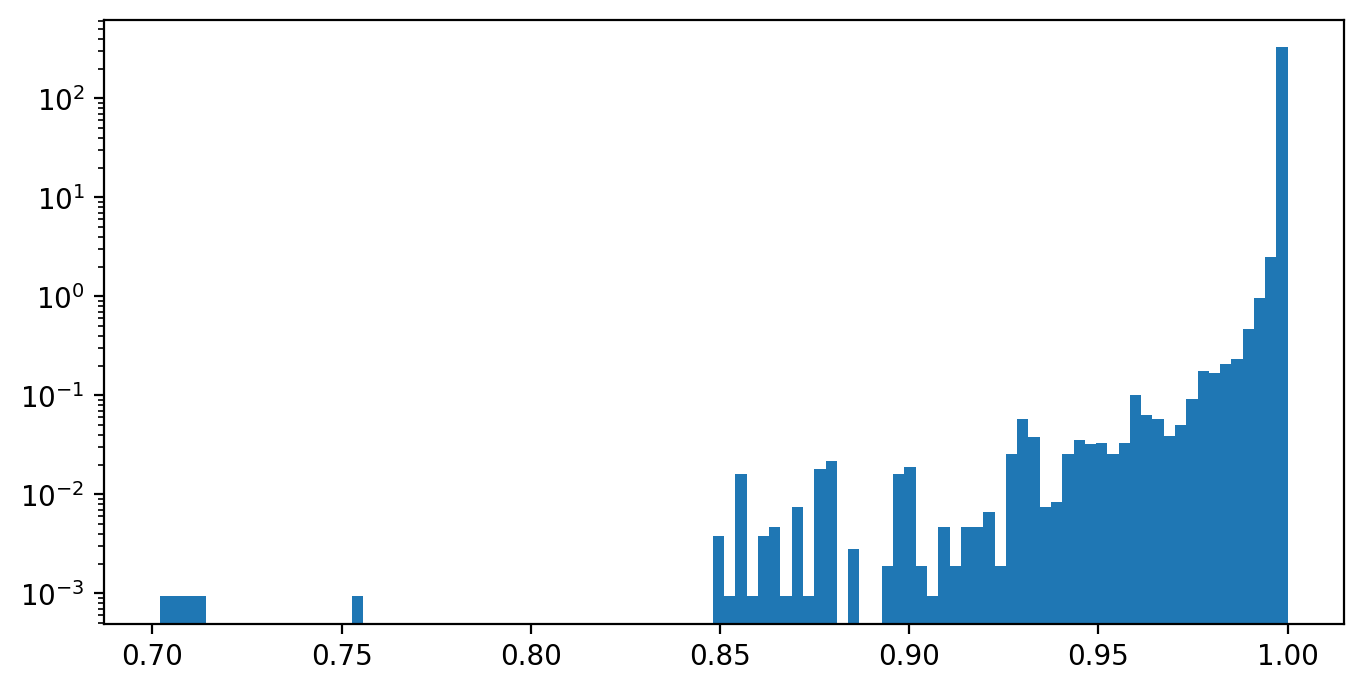

In [28]:
_ = plt.hist(bgs_segment(*Xp.T), 100, density=True)
plt.semilogy()

In [26]:
bgs_segment(*Xp.T).var()

1.281413507428087e-05

In [139]:
FIT_DIR = '../data/slim_sims/segment_logL_logrbp_logrf_wide/fits/'

models = [f for f in os.listdir(FIT_DIR)]
#models = ['segment_uniform_mu']
only_model = 'segment_logL_logrbp_logrf_wide'
res = {m: load_learnedfuncs_in_dir(os.path.join(FIT_DIR, m)) for m in models}[only_model]


In [140]:
res[(0, 0, 0, 0, 2)]

{2: <bgspy.learn.LearnedB at 0x7fedc46be160>,
 1: <bgspy.learn.LearnedB at 0x7fedc45fdb20>,
 3: <bgspy.learn.LearnedB at 0x7fedc4390e50>,
 0: <bgspy.learn.LearnedB at 0x7fedc444f100>}

In [17]:
Xp = Xps[0]

rep = 0

ARCH = (0, 0, 0, 0, 2)
dnn = res[ARCH][rep].func.predict(Xp)
t = bgs_segment(*Xp.T)

ax = sns.scatterplot(x=t, y=dnn, hue=Xp[:, 1],  palette="dark", linewidth=0)
o = min(0.8, 1)
ax.set_xlim(0.95, 1.01)
ax.set_ylim(0.95, 1.01)
ax.set_xlabel('theory')
ax.set_ylabel(f'ML B fit {rep}')
ax.axline((o, o), slope=1)


NameError: name 'Xps' is not defined

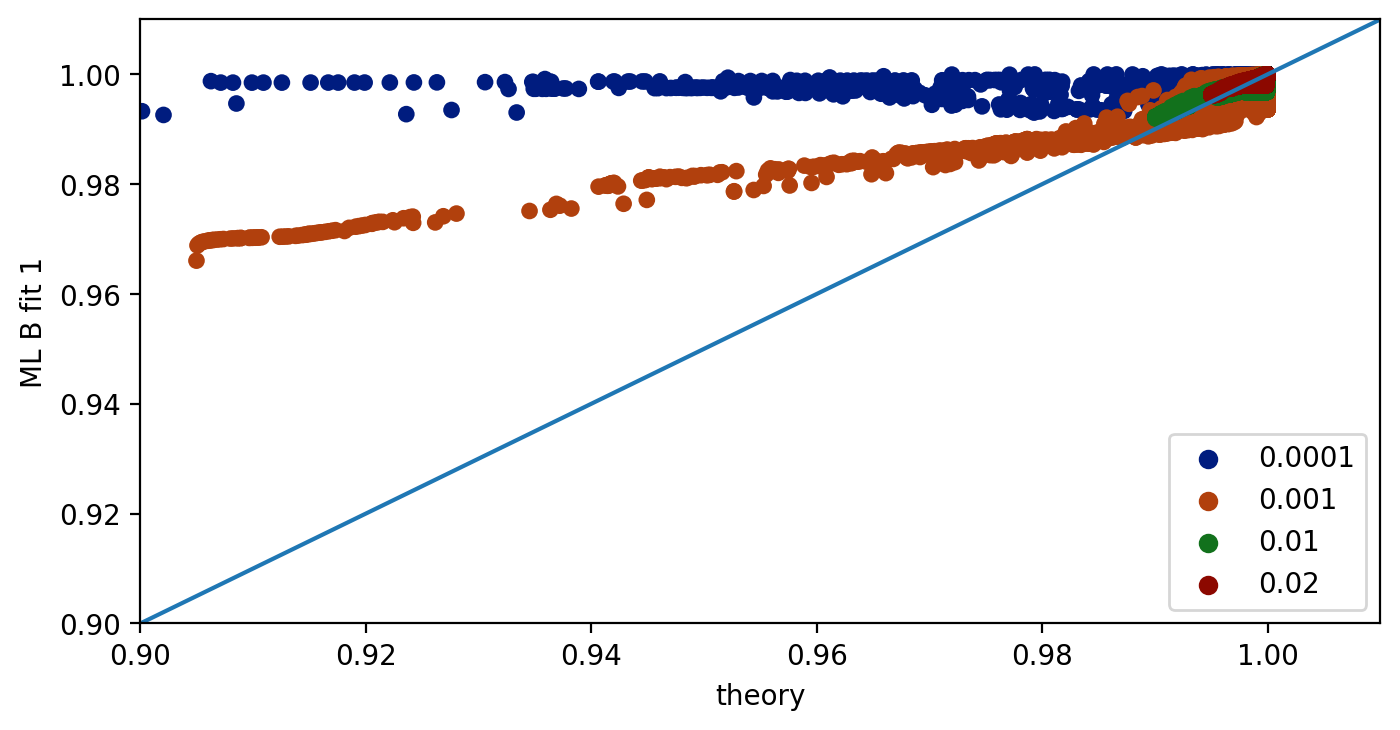

In [197]:
Xp = Xps[0]

rep = 1

ARCH = (0, 0, 0, 0, 2)
dnn = res[ARCH][rep].func.predict(Xp)
t = bgs_segment(*Xp.T)

ax = sns.scatterplot(x=t, y=dnn, hue=Xp[:, 1],  palette="dark", linewidth=0)
o = min(0.8, 1)
ax.set_xlim(0.90, 1.01)
ax.set_ylim(0.90, 1.01)
ax.set_xlabel('theory')
ax.set_ylabel(f'ML B fit {rep}')
ax.axline((o, o), slope=1)


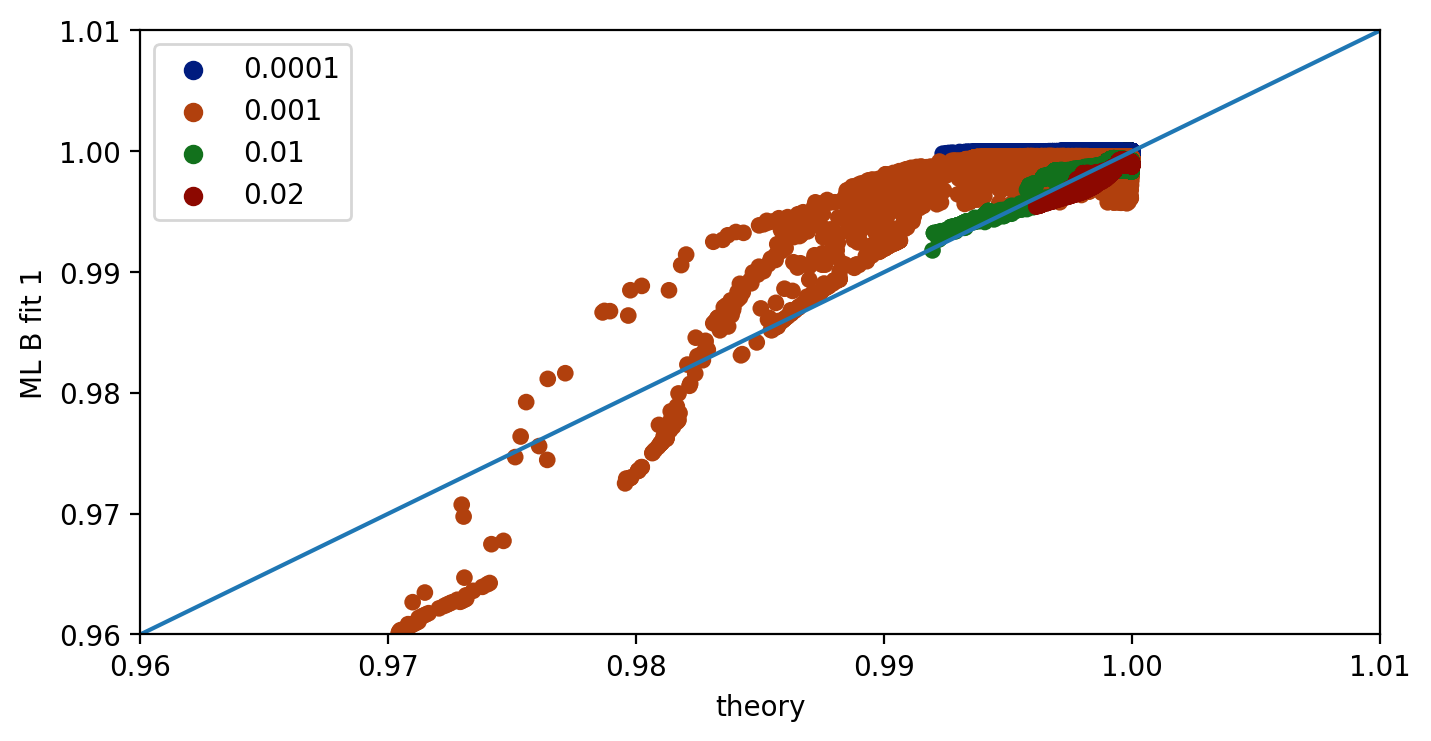

In [199]:
Xp = Xps[0]

rep = 1

ARCH = (0, 0, 0, 0, 2)
dnn1 = res[ARCH][0].func.predict(Xp)
dnn2 = res[ARCH][1].func.predict(Xp)
t = bgs_segment(*Xp.T)

ax = sns.scatterplot(x=dnn2, y=dnn1, hue=Xp[:, 1],  palette="dark", linewidth=0)
o = min(0.8, 1)
ax.set_xlim(0.96, 1.01)
ax.set_ylim(0.96, 1.01)
ax.set_xlabel('theory')
ax.set_ylabel(f'ML B fit {rep}')
ax.axline((o, o), slope=1)


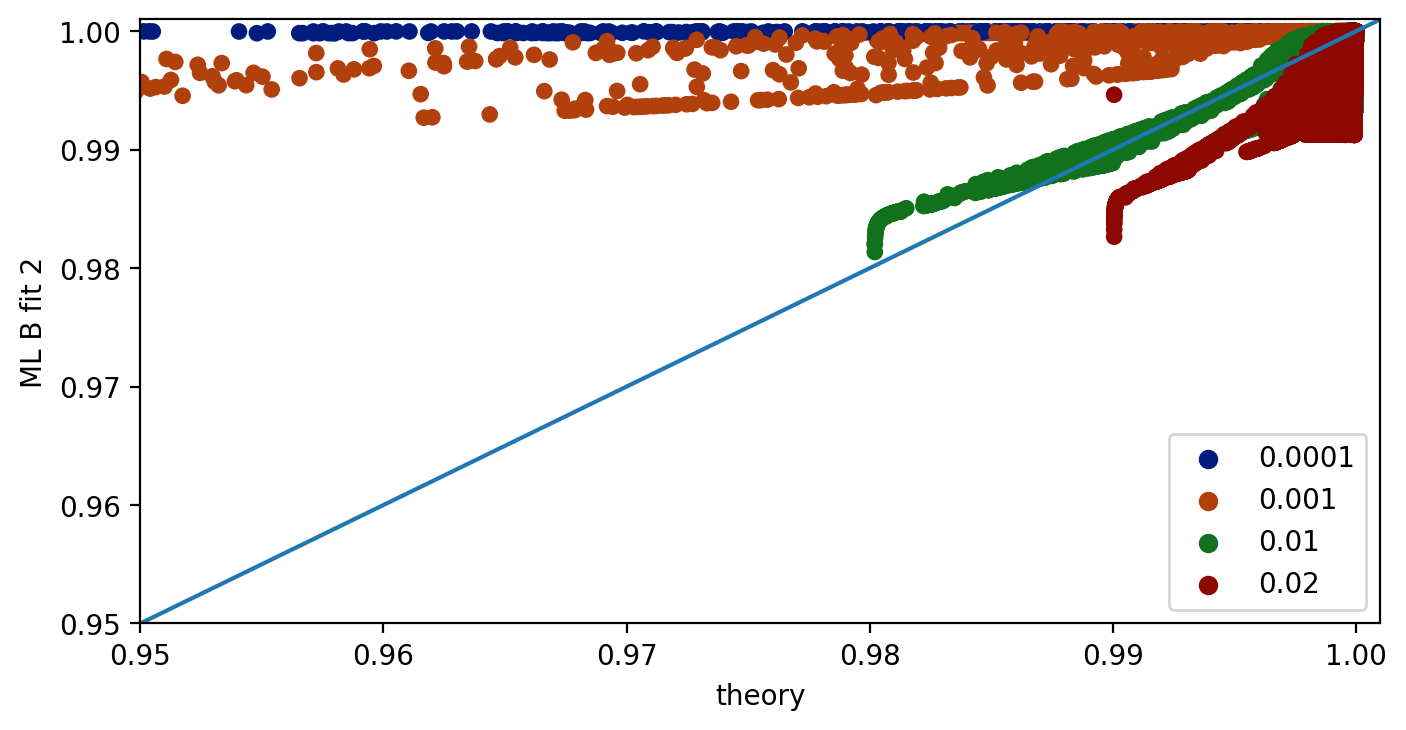

In [145]:
Xp = Xps[0]

rep = 2

ARCH = (0, 0, 0, 0, 2)
dnn = res[ARCH][rep].func.predict(Xp)
t = bgs_segment(*Xp.T)

ax = sns.scatterplot(x=t, y=dnn, hue=Xp[:, 1],  palette="dark", linewidth=0)
o = min(0.8, 1)
ax.set_xlim(0.95, 1.001)
ax.set_ylim(0.95, 1.001)
ax.set_xlabel('theory')
ax.set_ylabel(f'ML B fit {rep}')
ax.axline((o, o), slope=1)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


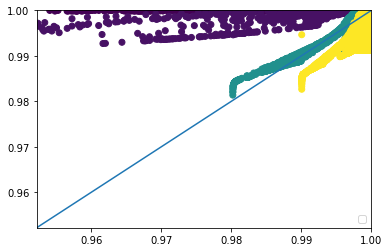

In [49]:
fig, ax = plt.subplots()
ax.scatter(t, a, c=Xps[0][:, 1])
#ax.scatter(c, b)
o = min(a.min(), b.min()) * 0.999
ax.axline((o, o), slope=1)
ax.set_xlim(o, 1)
ax.set_ylim(o, 1)
ax.legend()

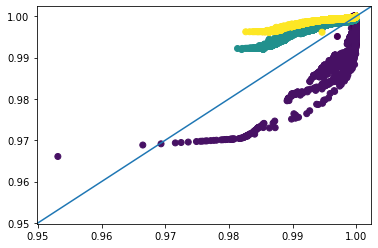

In [36]:
fig, ax = plt.subplots()
ax.scatter(a, b, c= Xps[0][:, 1])
#ax.scatter(c, b)
o = min(a.min(), b.min()) * 0.999
ax.axline((o, o), slope=1)



Compute Xps for all chromosomes? and look at ranges?

In [122]:
b = bf.func.predict(Xp)

In [123]:
np.prod(b.reshape((nw*nt, nsegs)), axis=1).reshape((nw, nt))

array([[9.7509283e-01, 7.9837114e-01, 3.3231109e-01, 3.2637003e-01],
       [8.5641742e-01, 6.6751868e-02, 3.5187616e-03, 1.7591896e-03],
       [3.1599152e-01, 2.4528429e-23, 6.7071712e-18, 1.9489467e-19]],
      dtype=float32)

In [85]:
ml_res = defaultdict(list)
theory_res = defaultdict(list)
bs = []

for i in range(Xp.shape[0]):
    theory = bgs_segment(*Xp[i, :])
    ml = b[i]
    ml_res[(Xp[i, 0], Xp[i, 1])].append(ml)
    theory_res[(Xp[i, 0], Xp[i, 1])].append(theory)    
    bs.append(ml)

In [86]:
ml_s = np.empty((nw, nt))
theory_s = np.empty((nw, nt))
n = np.empty((nw, nt))

for i in range(nw):
    for j in range(nt):
        ml_s[i, j] = np.prod(ml_res[(w[i], t[j])])
        theory_s[i, j] = np.prod(theory_res[(w[i], t[j])])
        #n[i, j] = len(ml_res[(w[i], t[j])])

In [97]:
np.round(theory_s, 2)

array([[0.11, 0.48, 0.79, 0.83],
       [0.  , 0.  , 0.09, 0.16],
       [0.  , 0.  , 0.  , 0.  ]])

In [92]:
np.round(ml_s, 4)

array([[0.9751, 0.7984, 0.3323, 0.3264],
       [0.8564, 0.0668, 0.0035, 0.0018],
       [0.316 , 0.    , 0.    , 0.    ]])

In [93]:
Xp

array([[1.00000000e-09, 1.00000000e-04, 7.72000000e+02, 1.82267907e-08,
        1.00202769e-01],
       [1.00000000e-09, 1.00000000e-04, 3.59000000e+02, 1.00000001e-07,
        9.95751310e-02],
       [1.00000000e-09, 1.00000000e-04, 1.73000000e+02, 1.00000001e-07,
        9.95060228e-02],
       ...,
       [1.00000000e-07, 2.00000000e-02, 1.00000000e+03, 1.84439894e-08,
        1.02031694e-01],
       [1.00000000e-07, 2.00000000e-02, 1.00000000e+03, 1.84439894e-08,
        1.02051732e-01],
       [1.00000000e-07, 2.00000000e-02, 1.00000000e+03, 1.84439894e-08,
        1.02071734e-01]])

In [116]:
np.round(np.exp(bgs_segment(*Xp.T, log=True).reshape((nw*nt, nsegs)).sum(axis=1)), 2).reshape((nw, nt))

array([[0.11, 0.48, 0.79, 0.83],
       [0.  , 0.  , 0.09, 0.16],
       [0.  , 0.  , 0.  , 0.  ]])

In [104]:
bgs_segment(*Xp[-1, :].T)

array(0.99991893)

In [106]:
Xp[-1, :]

array([1.00000000e-07, 2.00000000e-02, 1.00000000e+03, 1.84439894e-08,
       1.02071734e-01])

In [107]:
bgs_segment(1.00000000e-07, 2.00000000e-02, 1.00000000e+03, 1.84439894e-08, 1.02071734e-01)

array(0.9900679)